# EDA & Data Cleaning - Echo Chambers

The following code cells process the raw data as downloaded from [MovieLens](https://grouplens.org/datasets/movielens/) in preparation for analysis.

## Local Code Imports - Do not delete

In [1]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [2]:
# DO NOT REMOVE This
%reload_ext autoreload

In [3]:
# Uncomment to filter warnings
#import warnings
# warnings.filterwarnings('ignore')

In [4]:
# DO NOT REMOVE
# import local src module -
# src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import model as mdl
from src import make_data as md


def test_src():
    mdl.test_model()

    return 1

In [9]:
test_src()

In Model


1

## Code Imports

In [5]:
# Some standard imports
import seaborn as sns
import numpy as np
import pandas as pd

# import pandas_profiling as pp  # uncomment if you want to use pandas_profiling
# must have pandas_profiling installed locally.
##
# pip install pandas-profiling
##

import matplotlib.pyplot as plt
%matplotlib inline

# Data Description

The project utilizes the MovieLens dataset (Harper & Konstan, 2015). The MovieLens dataset is an open source data set containing 27,753,444 movie ratings from 283,228 users for 58,098 movies. The ratings are on a five-star scale range from 0.5 stars to 5 stars in 0.5 star increments. The files include data from January 09, 1995 and September 26, 2018. The data set includes a random sample of users with at least 1 movie rating.

### Data Dictionary

**Dictionary for the Ratings.csv file:**

    userId - A unique identifier for each user in the dataset

    movieId - A unique identifier for each movie in the dataset

    rating - A user's rating for a given movie. The ratings utilize a five star system ranging from 0.5 stars to 5 stars in 0.5 star increments. 

    timestamp - The time at which the rating was made represented as seconds since midnight January 1, 1970 (UTC).


**Dictionary for the Movies.csv file:**

    movieId - A unique identifier for each movie in the dataset

    title - Title and release year for each movie

    Genre - Genres classifications for each movie

# EDA

## Load Data - All sources

In [78]:
ratings_df = pd.read_csv('../data/raw/ratings.csv')

## Data Summary

In [9]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [10]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [11]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
ratings_df.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

## Evaluating Users

In [33]:
user_counts = md.get_agg_counts(ratings_df, 'userId')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1053b45f8>]],
      dtype=object)

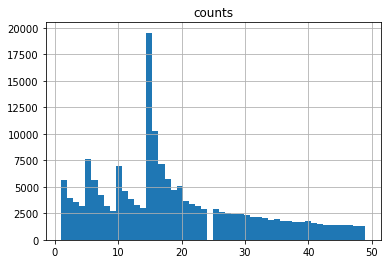

In [16]:
user_counts[user_counts > 10].hist(bins=50)

## Evaluating Movies

In [37]:
movie_counts = md.get_agg_counts(ratings_df, 'movieId')

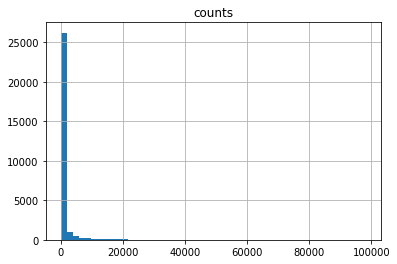

In [23]:
movie_counts[movie_counts > 5].hist(bins=50)

# Data Cleaning

The next cell filters the ratings dataframe to create a dataframe that includes only those users with 10 or more recommendations. The cutoff for the minimum number of movie ratings was set to 10 to coincide with the number of recommendations new users will be asked to make to get recommendations from the augmented model. 

In [43]:
ratings_filtered = md.filter_dataframe(
    ratings_df, 'userId', '>=', column='movieId', value=10)
ratings_filtered.head()

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


The next cell filters the dataframe further to create a dataframe that includes only those movies with more than 5 recommendations.

In [91]:
ratings_processed = md.filter_dataframe(
    ratings_filtered, 'movieId', '>', column='userId', value=5)
ratings_processed.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


Lastly, the new filtered dataframe is saved to the processed data folder.

In [94]:
ratings_processed.to_csv('../data/processed/ratings_processed.csv')

# Movie Data

The movie dataset contains information on the title, release date, and genre of 58,098 movies. The recommendation function developed through this project utilizes several versions of movie dataset. The following code creates a dataset of most rated movies (i.e., movies with at more than 50 user ratings) and the 100 top rated movies (based on highest mean rating) among the most rated movies. 

In [5]:
movies_df = pd.read_csv('../data/raw/movies.csv')
movie_ratings = pd.read_csv(
    '../data/processed/ratings_processed.csv', index_col=['Unnamed: 0'])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [195]:
mean_ratings = movie_ratings.groupby(['movieId'])['rating'].agg('mean')
mean_ratings = mean_ratings.reset_index()
mean_ratings.columns = ['movieId', 'rating']

In [196]:
total_recs = (movie_ratings['movieId'].value_counts()).reset_index()
total_recs.columns = ['movieId', 'total_recs']
total_recs = total_recs[total_recs['total_recs'] > 50]

In [197]:
most_rated = pd.merge(total_recs, mean_ratings, how='left', on='movieId')
most_rated_sorted = most_rated.sort_values(by='rating', ascending=False)

In [198]:
top_100 = most_rated_sorted[:100]
top_100 = pd.merge(top_100, movies_df, how='left', on='movieId')

In [199]:
top_100.to_csv('../data/processed/top_100.csv')

In [183]:
most_rated_df = pd.merge(most_rated_sorted, movies_df,
                         how='left', on='movieId')
most_rated_df.drop(['total_recs'], axis=1, inplace=True)

In [184]:
most_rated_df.drop(['rating'], axis=1, inplace=True)

In [186]:
most_rated_df.to_csv('../data/processed/most_rated.csv')